In [29]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)



In [31]:
import sqlite3
import os

db_path = "state_db/chatbot.db"

# Check if the database file exists
if not os.path.exists(db_path):
  # If it doesn't exist, create a new database file
  conn = sqlite3.connect(db_path, check_same_thread=False)
  print(f"New database created at {db_path}")
else:
  # If it exists, connect to the existing database
  conn = sqlite3.connect(db_path, check_same_thread=False)
  print(f"Connected to existing database at {db_path}")


Connected to existing database at state_db/chatbot.db


In [32]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)


In [36]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import START, StateGraph, END
from langgraph.graph import MessagesState


class State(MessagesState):
    summary: str


# Define the logic to call the model
def call_model(state: State):
    
    summary = state.get("summary", "")

    if summary:
        messages = [SystemMessage(content = f"The summary of the chat so far is:, {summary}")] + state["messages"]
    else:
        messages = state['messages']

    messages = llm.invoke(messages)
    return {"messages" : messages}

def summarize(state: State):

    summary = state.get("summary", "")

    if summary: 
        prompt = f"Here is the summary of the conversation so far: {summary}\n extend the summary by using the current chat"
        messages = state["messages"] + [HumanMessage(content=prompt)]
        response = llm.invoke(messages) 

    else:
        prompt = "Create a summary of the conversation so far"
        messages = state["messages"] + [HumanMessage(content=prompt)]
        response = llm.invoke(messages)
    print("#####summary executed#####")
    messages_trimmed = [RemoveMessage(id = m.id) for m in messages[:-2]]
    
    return {"messages" : messages_trimmed, "summary" : response.content}

def decide_to_summarize(state: State):
    """Return the next node to execute."""
    messages = state["messages"]

    if len(messages) > 3:
        return "summarize"
    else:
        return END





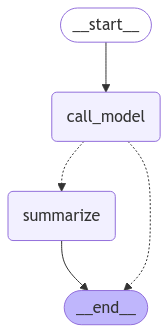

In [37]:
from IPython.display import Image, display
graph_builder = StateGraph(State)

graph_builder.add_node("call_model", call_model )
graph_builder.add_node("summarize", summarize )

graph_builder.add_edge(START, "call_model")
graph_builder.add_conditional_edges("call_model", decide_to_summarize )
graph_builder.add_edge("summarize", END)

graph = graph_builder.compile(checkpointer = memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
config = {"configurable": {"thread_id": "1"}}
# Start conversation
input_message = HumanMessage(content="hi! I'm Arun")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-2:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-2:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the Deccan chargers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-2:]:
    m.pretty_print()

#####summary executed#####
================================== Ai Message ==================================

Hello Arun! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Arun.
#####summary executed#####
================================== Ai Message ==================================

That's great to hear! The Deccan Chargers are a popular cricket team in the Indian Premier League. Is there anything specific you like about the team?


In [47]:
graph_state = graph.get_state(config)
print(graph_state.values['summary'])

Arun, the user, expressed his fondness for the Deccan Chargers cricket team in the Indian Premier League. The AI acknowledged his preference and shared information about the team. Arun then confirmed his name as Arun and continued the conversation.


In [48]:
conn.close()
